# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

In [1]:
from IPython.display import display, HTML   
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

### Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
total_tr_len = len(cifar10_train)

X={}
Y=[]
for i in range(len(cifar10_train)):
    data = cifar10_train[i][0].numpy()
    label = cifar10_train[i][1]

    if label in X:
        X[label].append(data)
    else:
        X[label] = []
        X[label].append(data)
        Y.append(label)

for label in X:
    X[label] = np.array(X[label])
Y=np.array(Y)

alpha = 1
n_users = 50

In [5]:
user_train_data_non_tensors = [[] for _ in range(n_users)]
user_train_label_non_tensors = [[] for _ in range(n_users)]

for label in Y:
    alpha_list = [alpha for _ in range(n_users)]
    probs = np.random.dirichlet(alpha_list)

    taken_index = 0

    for i, prob in enumerate(probs):
        if i == n_users - 1:
            user_train_data_non_tensors[i].extend(X[label][taken_index:])
            user_train_label_non_tensors[i].extend([label for _ in range(len(X[label]) - taken_index)])
        else:
            n_sample = math.floor(prob * len(X[label]))

            user_train_data_non_tensors[i].extend(X[label][taken_index : taken_index + n_sample])
            user_train_label_non_tensors[i].extend([label for _ in range(n_sample)])
            taken_index += n_sample

user_train_data_tensors = []
user_train_label_tensors = []

user_tr_len = []

for i in range(n_users):

    if len(user_train_data_non_tensors[i]) != len(user_train_label_non_tensors[i]):
        sys.exit(f"Shape does not match user_train_data_non_tensors[i] hsa {len(user_train_data_non_tensors[i])}, while user_train_label_non_tensors[i] has {len(user_train_label_non_tensors[i])}")
   
    
    num_data = len(user_train_data_non_tensors[i])
    user_tr_len.append(num_data)

    user_train_data_tensors.append(torch.from_numpy(np.array(user_train_data_non_tensors[i])).type(torch.FloatTensor))
    user_train_label_tensors.append(torch.from_numpy(np.array(user_train_label_non_tensors[i])).type(torch.LongTensor))

    r=np.arange(num_data)
    
    np.random.shuffle(r)    

    user_train_data_tensors[i] = user_train_data_tensors[i][r]
    user_train_label_tensors[i] = user_train_label_tensors[i][r]

    print(f'user {i} has {user_train_data_tensors[i].shape[0]} train data, and {user_train_label_tensors[i].shape[0]} train labels')
    


user 0 has 818 train data, and 818 train labels
user 1 has 804 train data, and 804 train labels
user 2 has 1071 train data, and 1071 train labels
user 3 has 739 train data, and 739 train labels
user 4 has 1082 train data, and 1082 train labels
user 5 has 1254 train data, and 1254 train labels
user 6 has 861 train data, and 861 train labels
user 7 has 1287 train data, and 1287 train labels
user 8 has 1152 train data, and 1152 train labels
user 9 has 945 train data, and 945 train labels
user 10 has 1025 train data, and 1025 train labels
user 11 has 656 train data, and 656 train labels
user 12 has 700 train data, and 700 train labels
user 13 has 1341 train data, and 1341 train labels
user 14 has 799 train data, and 799 train labels
user 15 has 427 train data, and 427 train labels
user 16 has 1250 train data, and 1250 train labels
user 17 has 1415 train data, and 1415 train labels
user 18 has 766 train data, and 766 train labels
user 19 has 848 train data, and 848 train labels
user 20 has 

In [6]:
X2 = []
Y2 = []

for i in range(len(cifar10_test)):
    X2.append(cifar10_test[i][0].numpy())
    Y2.append(cifar10_test[i][1])

X2=np.array(X2)
Y2=np.array(Y2)

half_index = len(X2) // 2

val_data= X2[:half_index]
val_label= Y2[:half_index]

te_data=X2[half_index:]
te_label=Y2[half_index:]

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

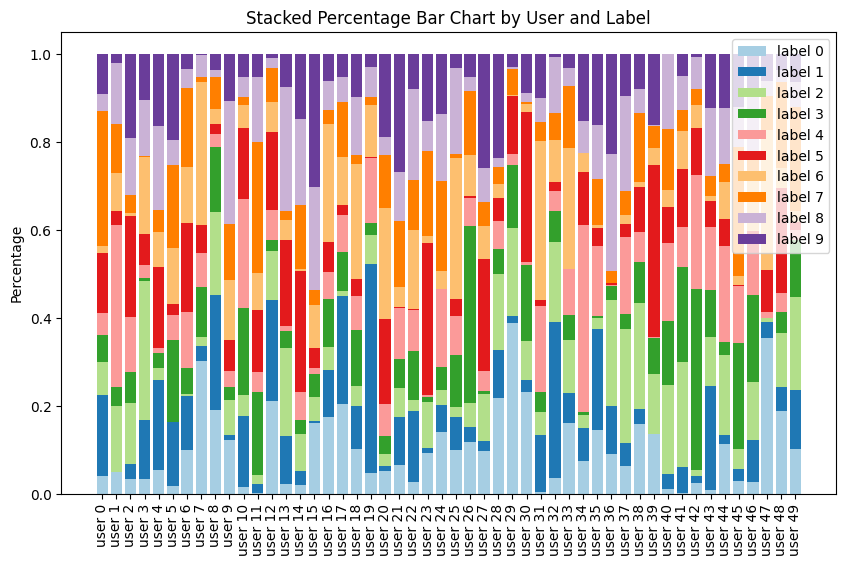

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Example data
users = [f"user {i}" for i in range(50)]
labels = [f"label {i}" for i in range(10)]


percentages = []
for user_data in user_train_label_non_tensors:
    temp_holder = []
    for label in range(10):
        temp_holder.append(user_data.count(label))
    percentages.append(temp_holder)

percentages = np.array(percentages)

p2 = []
for percentage in percentages:
    sum = np.sum(percentage)
    p2.append(percentage/sum)

percentages = np.array(p2)


# Assuming 'percentages' is populated correctly as shown previously
# Convert percentages to cumulative sum for stacking
cumulative = np.cumsum(percentages, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each ethnicity, ensuring there are enough colors for all labels
colors = plt.cm.Paired(range(len(labels))) # Repeating colors to match the number of labels

# Create stacked bars
for i in range(len(labels)):  # Iterate over the number of labels
    if i == 0:
        ax.bar(users, percentages[:, i], color=colors[i], label=labels[i])
    else:
        ax.bar(users, percentages[:, i], bottom=cumulative[:, i-1], color=colors[i], label=labels[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Stacked Percentage Bar Chart by User and Label')
ax.set_xticks(np.arange(len(users)))
ax.set_xticklabels(users, rotation=90)  # Rotate labels if needed
ax.legend()


plt.savefig('./non_iid_user_label_distribution.png', bbox_inches='tight')
plt.show()


## Code for Multi-krum aggregation algorithm

In [ ]:
def multi_krum(all_updates, n_attackers, multi_k=False):
    print("all_updates.shape: ", all_updates.shape)
    candidates = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(remaining_updates) > 2 * n_attackers + 2:
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

        distances = torch.sort(distances, dim=1)[0]
        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]

        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        candidates = remaining_updates[indices[0]][None, :] if not len(candidates) else torch.cat((candidates, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)
        if not multi_k:
            break
    print("candidates", len(candidates))

    aggregate = torch.mean(candidates, dim=0)

    return aggregate, np.array(candidate_indices)

## Code for Bulyan aggregation algorithm

In [ ]:
def bulyan(all_updates, n_attackers):
    n_users = all_updates.shape[0]
    bulyan_cluster = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(bulyan_cluster) < (n_users - 2 * n_attackers):
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
        # print(distances)

        distances = torch.sort(distances, dim=1)[0]

        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]
        if not len(indices):
            break
        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        bulyan_cluster = remaining_updates[indices[0]][None, :] if not len(bulyan_cluster) else torch.cat((bulyan_cluster, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)

    # print('dim of bulyan cluster ', bulyan_cluster.shape)

    n, d = bulyan_cluster.shape
    param_med = torch.median(bulyan_cluster, dim=0)[0]
    sort_idx = torch.argsort(torch.abs(bulyan_cluster - param_med), dim=0)
    sorted_params = bulyan_cluster[sort_idx, torch.arange(d)[None, :]]

    return torch.mean(sorted_params[:n - 2 * n_attackers], dim=0), np.array(candidate_indices)

## our_attack_mean_std
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}| + \lambda_2 |\bar{\sigma_{mean\ benige\ users}} - \bar{\sigma_{attacker(s)}}|)$

In [ ]:
def our_attack_mean_std(all_updates, model_re, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors):
    
    all_updates_deviation = all_updates.std(dim=1, keepdim=True) # [50, 1]
    benign_std_avg = all_updates_deviation.mean() # [1, 1]

    all_updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)  # [50,1]
    benign_abs_mean_avg = all_updates_abs_mean.mean() # [1, 1]

    result_attacker_grads = [] 
    attacker_grads = all_updates[:n_attacker]


    for index, attacker_grad in enumerate(attacker_grads):

        attacker_tr_data_tensor = user_train_data_tensors[index].cuda()
        attacker_tr_label_tensor = user_train_label_tensors[index].cuda()

        def rosen(X):
            X = X.cuda()
            attacker_abs_mean = X.abs().mean()
            attacker_std = X.abs().std()

        #     # Reshape X into the shape of fed_model.parameters
            fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
            optimizer_fed = SGD(fed_model.parameters(), lr=0.5)

            optimizer_fed.zero_grad()
            model_grads=[]
            start_idx = 0
            for i, param in enumerate(fed_model.parameters()):
                param_=X[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
                start_idx=start_idx+len(param.data.view(-1))
                param_=param_.cuda()
                model_grads.append(param_)
            optimizer_fed.step(model_grads)

            return -criterion(fed_model(attacker_tr_data_tensor), attacker_tr_label_tensor) + torch.abs(benign_std_avg - attacker_abs_mean) + torch.abs(benign_abs_mean_avg - attacker_std)
        
        from torchmin import minimize

        res = minimize(
            rosen, attacker_grad, 
            method='l-bfgs', 
            options=dict(line_search='strong-wolfe'),
            max_iter=100,
            disp=False
        )
        result_attacker_grads.append(res.grad)
        # if result_attacker_grads is None:
        #     result_attacker_grads = res.grad
        # else:
        #     result_attacker_grads.append(res.grad)

    return torch.stack(result_attacker_grads).cuda()

## Execute our AGR-tailored attack on Bulyan

In [ ]:
batch_size=250
resume=0

nepochs= 100

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size
            # nbatches = 1000//batch_size

            # inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            # targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs = user_train_data_tensors[i]
            targets = user_train_label_tensors[i]

            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                # print(param.shape)
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
       
        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//n_users)
            agg_grads = torch.mean(user_grads[:n_attacker], 0)

            # No attack
            # malicious_grads = user_grads

            # Attack
            mal_updates = our_attack_mean_std(user_grads, agg_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
            
        malicious_grads = user_grads
        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        # Store history of malicious_grads
        # average_tensor = malicious_grads.mean(dim=1, keepdim=True)
        # median_tensor = malicious_grads.median(dim=1, keepdim=True).values
        # lower_quartile = malicious_grads.quantile(0.25, dim=1, keepdim=True)
        # upper_quartile = malicious_grads.quantile(0.75, dim=1, keepdim=True)
        # std = malicious_grads.std(dim=1, keepdim=True)

        # mean_abs_tensor = malicious_grads.abs().sum(dim=1, keepdim=True)

        # past_abs_sum.append(mean_abs_tensor)
        # past_mean.append(average_tensor)
        # past_median.append(median_tensor)
        # past_lower_quartile.append(lower_quartile)
        # past_upper_quartile.append(upper_quartile)
        # past_std.append(std)


        # pickle.dump(past_abs_sum,open('./past_abs_sum.pkl','wb'))
        # pickle.dump(past_mean,open('./past_mean.pkl','wb'))
        # pickle.dump(past_median,open('./past_median.pkl','wb'))
        # pickle.dump(past_lower_quartile,open('./past_lower_quartile.pkl','wb'))
        # pickle.dump(past_upper_quartile,open('./past_upper_quartile.pkl','wb'))
        # pickle.dump(past_std,open('./past_std.pkl','wb'))

        agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no_attack.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("has_attack_"+col)
    plt.savefig('./has_attack_' + col + '.png')
    plt.show()